# X-ray Chest Classification

## Deep Learning Model for Chest X-ray Classification

This notebook implements a convolutional neural network (CNN) to classify chest X-ray images into three categories:
- Normal
- COVID-19
- Pneumonia

**Dataset Source**: [COVID Pneumonia Normal Chest X-ray Images](https://www.kaggle.com/datasets/sachinkumar413/covid-pneumonia-normal-chest-xray-images)


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import os
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
from utils import train_one_epoch, evaluate, get_device, set_seed, save_experiment_json, plot_history, performance, save_checkpoint, EarlyStopping
import torchsummary
set_seed(42)

In [3]:
CLASSES = ['COVID', 'NORMAL', 'PNEUMONIA']

In [4]:
project_root = os.getcwd()
BASE_DIR = os.path.basename(project_root)
DEVICE = get_device()
print("project root: ", project_root)
print("base dir: ", BASE_DIR)
print('device: ', DEVICE)

project root:  /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification
base dir:  xray_chest_classification
device:  mps


# 1. Dataset loading

In [5]:
class ChestXrayDataset(Dataset):
    def __init__(self, data_dir, transform):
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for class_name in CLASSES:
            class_path = os.path.join(data_dir, class_name)
            for image in os.listdir(class_path):
                self.images.append(os.path.join(class_path, image))
                self.labels.append(class_name)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        img = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        y = CLASSES.index(label)
        transformed_image = self.transform(img)
        original_image = torch.tensor(cv2.resize(np.asarray(img), (224, 224)))

        return original_image, transformed_image, torch.tensor(y)

In [6]:
train_dir = "data/train"
val_dir = "data/val"
test_dir = "data/test"

BATCH_SIZE = 32

train_transform = transforms.Compose(
    [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

eval_transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

train_dataset = ChestXrayDataset(train_dir, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

val_dataset = ChestXrayDataset(val_dir, transform=eval_transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True  )

test_dataset = ChestXrayDataset(test_dir,transform=eval_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

print("Train loader size: ", len(train_loader))
print("Train loader size: ", len(val_loader))
print("Train loader size: ", len(test_loader))

Train loader size:  131
Train loader size:  17
Train loader size:  17


In [7]:
original_img, inputs, labels = next(iter(train_loader))

/Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


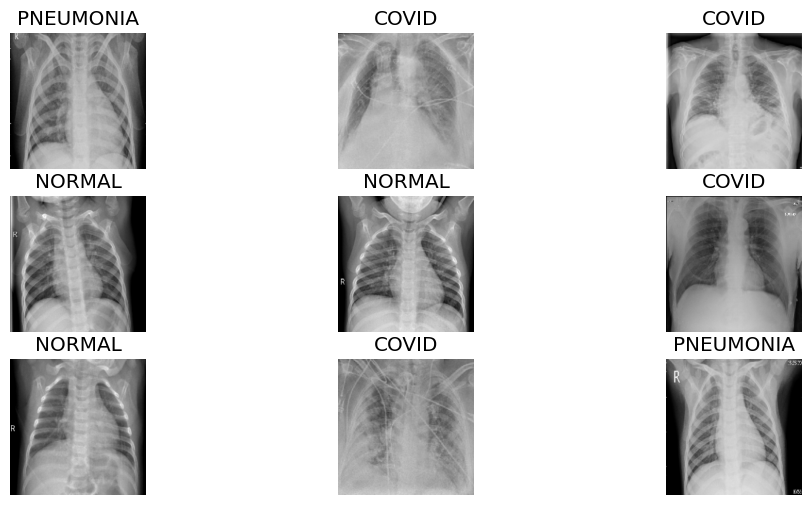

In [8]:
plt.figure(figsize=(12, 6))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(
        original_img[i].cpu().detach().numpy().reshape(224, 224, 3).astype("uint8")
    )
    plt.title(f"{CLASSES[labels[i]]}")
    plt.axis("off")

# 2. Baseline Model

# 3. Reference Model: EfficientNet (Transfer Learning)



In [9]:
from model import EfficientAdvanced

In [10]:
EPOCHS_STAGE_1 = 10  
LR_STAGE_1 = 1e-3  
EPOCHS_STAGE_2 = 20  
LR_STAGE_2 = 1e-5  
MODEL_NAME = "EfficientNetAdvanced"

### 3.1 Train head-only

# 4. Advanced model(Modified EfficientNet for model Improvement)

In [11]:
EPOCHS_STAGE_1 = 10  
LR_STAGE_1 = 1e-3  
EPOCHS_STAGE_2 = 20  
LR_STAGE_2 = 1e-5  
PATIENCE = 5
MODEL_NAME = "EfficientNetAdvanced"

In [12]:
from model import EfficientAdvanced

In [13]:
model = EfficientAdvanced(num_classes=len(CLASSES))
torchsummary.summary(model, (3, 224, 224), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 32, 112, 112]             864
       BatchNorm2d-2         [32, 32, 112, 112]              64
              SiLU-3         [32, 32, 112, 112]               0
            Conv2d-4         [32, 32, 112, 112]             288
       BatchNorm2d-5         [32, 32, 112, 112]              64
              SiLU-6         [32, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [32, 32, 1, 1]               0
            Conv2d-8              [32, 8, 1, 1]             264
              SiLU-9              [32, 8, 1, 1]               0
           Conv2d-10             [32, 32, 1, 1]             288
          Sigmoid-11             [32, 32, 1, 1]               0
SqueezeExcitation-12         [32, 32, 112, 112]               0
           Conv2d-13         [32, 16, 112, 112]             512
      BatchNorm2d-14         [32, 16, 1

In [14]:
history = {
    "model_name": MODEL_NAME,
    "train_losses": [],
    "val_losses": [],
    "train_accuracy": [],
    "val_accuracy": [],
    "val_f1": [],
    "val_recall": [],
    "val_auc": [],
    "best_accuracy": 0.0,
    "best_epoch": 0,
    "MODEL_SAVED_PATH": "",
}

### 4.1 Train Head-only first

In [15]:
model = model.to(device=DEVICE)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR_STAGE_1)
criterion = nn.CrossEntropyLoss()
MODEL_SAVED_PATH = os.path.join(
    project_root, f"model_checkpoints/{MODEL_NAME}.pth"
)
history["MODEL_SAVED_PATH"] = MODEL_SAVED_PATH
early_stopping = EarlyStopping(
    model_checkpoint=MODEL_SAVED_PATH, patience=PATIENCE, mode="max"
)

In [16]:
print(
    f"Training configuration for stage 1: LR = {LR_STAGE_1}, EPOCHS = {EPOCHS_STAGE_1}"
)

for epoch in range(EPOCHS_STAGE_1):
    # # Train
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, DEVICE
    )

    # Evaluate
    valid_loss, valid_acc = evaluate(
        model, val_loader, criterion, DEVICE
    )

    print(
        f"[{epoch + 1}/{EPOCHS_STAGE_1}] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}"
    )
    # Record metrics
    history["train_losses"].append(train_loss)
    history["val_losses"].append(valid_loss)
    history["train_accuracy"].append(train_acc)
    history["val_accuracy"].append(valid_acc)

    should_stop, best_score, best_epoch = early_stopping.should_stop(
        model, optimizer=optimizer, epoch=epoch, score=valid_acc
    )
    if should_stop:
        print(f"Early stopping: Stop at epoch: {epoch + 1} - Best epoch: {best_epoch} - Best score: {best_score}")
        break

    history["best_accuracy"] = best_score
    history["best_epoch"] = best_epoch

    print(
        f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['best_accuracy']:.4f}\n"
    )

Training configuration for stage 1: LR = 0.001, EPOCHS = 10


Evaluating: 100%|██████████| 17/17 [00:02<00:00,  5.73it/s]


[1/10] train_acc: 0.8072 - train_loss: 0.4989 - valid_acc: 0.9101 - valid_loss: 0.2284
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/EfficientNetAdvanced.pth
	- [current best] epoch: 1 - acc: 0.9101



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  7.83it/s]


[2/10] train_acc: 0.8632 - train_loss: 0.3695 - valid_acc: 0.9140 - valid_loss: 0.2233
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/EfficientNetAdvanced.pth
	- [current best] epoch: 2 - acc: 0.9140



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  7.54it/s]


[3/10] train_acc: 0.8766 - train_loss: 0.3451 - valid_acc: 0.9140 - valid_loss: 0.2329
	- [current best] epoch: 2 - acc: 0.9140



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  7.54it/s]


[4/10] train_acc: 0.8751 - train_loss: 0.3443 - valid_acc: 0.9312 - valid_loss: 0.1866
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/EfficientNetAdvanced.pth
	- [current best] epoch: 4 - acc: 0.9312



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  7.40it/s]


[5/10] train_acc: 0.8780 - train_loss: 0.3232 - valid_acc: 0.9197 - valid_loss: 0.2120
	- [current best] epoch: 4 - acc: 0.9312



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  7.59it/s]


[6/10] train_acc: 0.8828 - train_loss: 0.3173 - valid_acc: 0.9082 - valid_loss: 0.2203
	- [current best] epoch: 4 - acc: 0.9312



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  7.60it/s]


[7/10] train_acc: 0.8759 - train_loss: 0.3276 - valid_acc: 0.9293 - valid_loss: 0.1874
	- [current best] epoch: 4 - acc: 0.9312



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  7.53it/s]


[8/10] train_acc: 0.8790 - train_loss: 0.3140 - valid_acc: 0.9197 - valid_loss: 0.1867
	- [current best] epoch: 4 - acc: 0.9312



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  7.40it/s]

[9/10] train_acc: 0.8775 - train_loss: 0.3162 - valid_acc: 0.9197 - valid_loss: 0.2015
Early stopping: Stop at epoch: 9 - Best epoch: 4 - Best score: 0.9311663479923518


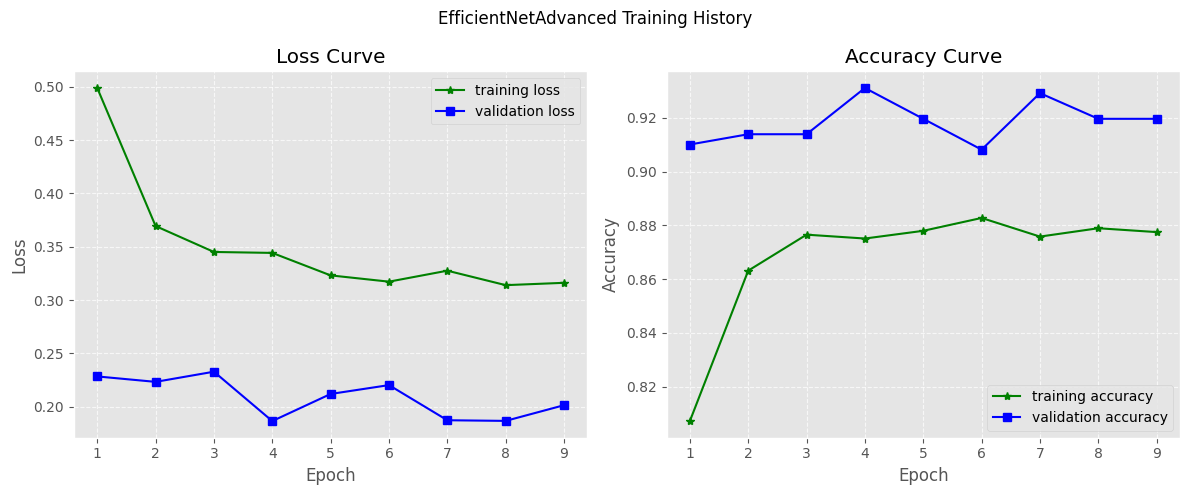

In [17]:
plot_history(history, f"{MODEL_NAME} Training History")

In [18]:
# Load the model again
checkpoint = torch.load(MODEL_SAVED_PATH)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

Getting predictions: 100%|██████████| 17/17 [00:02<00:00,  6.53it/s]

Accuracy score: 0.9427
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       163
           1       0.90      0.94      0.92       181
           2       0.94      0.92      0.93       180

    accuracy                           0.94       524
   macro avg       0.95      0.94      0.94       524
weighted avg       0.94      0.94      0.94       524



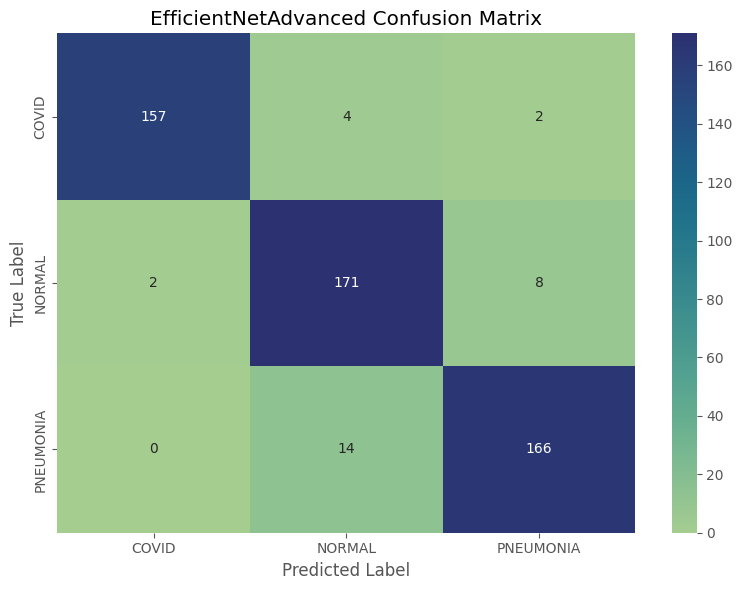

In [19]:
save_path = (
    f"{project_root}/results/{MODEL_NAME}_cfm.png"
)
performance(model, test_loader, DEVICE, MODEL_NAME,class_names=CLASSES, save_path=save_path)

In [20]:
# Save history
json_path = os.path.join(
    project_root,
    f"results/{MODEL_NAME}_history.json",
)
save_experiment_json(history, json_path)

History saved to /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/results/EfficientNetAdvanced_history.json


## 4.2 Fine-tune the model by unfreezing some layers

In [21]:
params = list(model.parameters())
print("Number of layers: ", len(params))

Number of layers:  217


In [22]:
num_unfreezed_layers = 50
for param in params[-num_unfreezed_layers:]:
    param.requires_grad = True
torchsummary.summary(model.to('cpu'), (3, 224, 224), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 32, 112, 112]             864
       BatchNorm2d-2         [32, 32, 112, 112]              64
              SiLU-3         [32, 32, 112, 112]               0
            Conv2d-4         [32, 32, 112, 112]             288
       BatchNorm2d-5         [32, 32, 112, 112]              64
              SiLU-6         [32, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [32, 32, 1, 1]               0
            Conv2d-8              [32, 8, 1, 1]             264
              SiLU-9              [32, 8, 1, 1]               0
           Conv2d-10             [32, 32, 1, 1]             288
          Sigmoid-11             [32, 32, 1, 1]               0
SqueezeExcitation-12         [32, 32, 112, 112]               0
           Conv2d-13         [32, 16, 112, 112]             512
      BatchNorm2d-14         [32, 16, 1

In [29]:
model = model.to(device=DEVICE)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR_STAGE_2)
criterion = nn.CrossEntropyLoss()
model_save_path = f"{project_root}/model_checkpoints/best_{MODEL_NAME}_finetuned.pth"
new_early_stopping = EarlyStopping(model_checkpoint=model_save_path, patience=PATIENCE)

In [31]:
TOTAL_EPOCHS = EPOCHS_STAGE_1 + EPOCHS_STAGE_2


print(
    f"Training configuration for stage 2: LR = {LR_STAGE_2}, EPOCHS = {EPOCHS_STAGE_2}"
)
for epoch in range(EPOCHS_STAGE_1, TOTAL_EPOCHS):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, DEVICE
    )
    valid_loss, valid_acc = evaluate(
        model, val_loader, criterion, DEVICE
    )

    print(
        f"[{epoch + 1}/{TOTAL_EPOCHS} (Fine-Tune)] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}"
    )

    should_stop, best_score, best_epoch = new_early_stopping.should_stop(
        model, optimizer=optimizer, epoch=epoch, score=valid_acc
    )
    if should_stop:
        print(
            f"Early stopping: Stop at epoch: {epoch + 1} - Best epoch: {best_epoch} - Best score: {best_score}"
        )
        break
    # Record metrics
    history["train_losses"].append(train_loss)
    history["val_losses"].append(valid_loss)
    history["train_accuracy"].append(train_acc)
    history["val_accuracy"].append(valid_acc)
    history["best_accuracy"] = best_score
    history["best_epoch"] = best_epoch

    print(
        f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['best_accuracy']:.4f}\n"
    )

Training configuration for stage 2: LR = 1e-05, EPOCHS = 20


Training:   0%|          | 0/131 [00:00<?, ?it/s]

/Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.79it/s]


[11/30 (Fine-Tune)] train_acc: 0.9237 - train_loss: 0.2148 - valid_acc: 0.9369 - valid_loss: 0.1537
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/best_EfficientNetAdvanced_finetuned.pth
	- [current best] epoch: 11 - acc: 0.9369



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  7.39it/s]


[12/30 (Fine-Tune)] train_acc: 0.9175 - train_loss: 0.2181 - valid_acc: 0.9388 - valid_loss: 0.1679
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/best_EfficientNetAdvanced_finetuned.pth
	- [current best] epoch: 12 - acc: 0.9388



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.49it/s]


[13/30 (Fine-Tune)] train_acc: 0.9134 - train_loss: 0.2281 - valid_acc: 0.9465 - valid_loss: 0.1486
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/model_checkpoints/best_EfficientNetAdvanced_finetuned.pth
	- [current best] epoch: 13 - acc: 0.9465



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.67it/s]


[14/30 (Fine-Tune)] train_acc: 0.9201 - train_loss: 0.2128 - valid_acc: 0.9426 - valid_loss: 0.1564
	- [current best] epoch: 13 - acc: 0.9465



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.62it/s]


[15/30 (Fine-Tune)] train_acc: 0.9273 - train_loss: 0.2093 - valid_acc: 0.9407 - valid_loss: 0.1459
	- [current best] epoch: 13 - acc: 0.9465



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.93it/s]


[16/30 (Fine-Tune)] train_acc: 0.9237 - train_loss: 0.2135 - valid_acc: 0.9312 - valid_loss: 0.1939
	- [current best] epoch: 13 - acc: 0.9465



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  7.02it/s]


[17/30 (Fine-Tune)] train_acc: 0.9204 - train_loss: 0.2102 - valid_acc: 0.9350 - valid_loss: 0.1576
	- [current best] epoch: 13 - acc: 0.9465



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  7.02it/s]

[18/30 (Fine-Tune)] train_acc: 0.9225 - train_loss: 0.2039 - valid_acc: 0.9407 - valid_loss: 0.1417
Early stopping: Stop at epoch: 18 - Best epoch: 13 - Best score: 0.9464627151051626


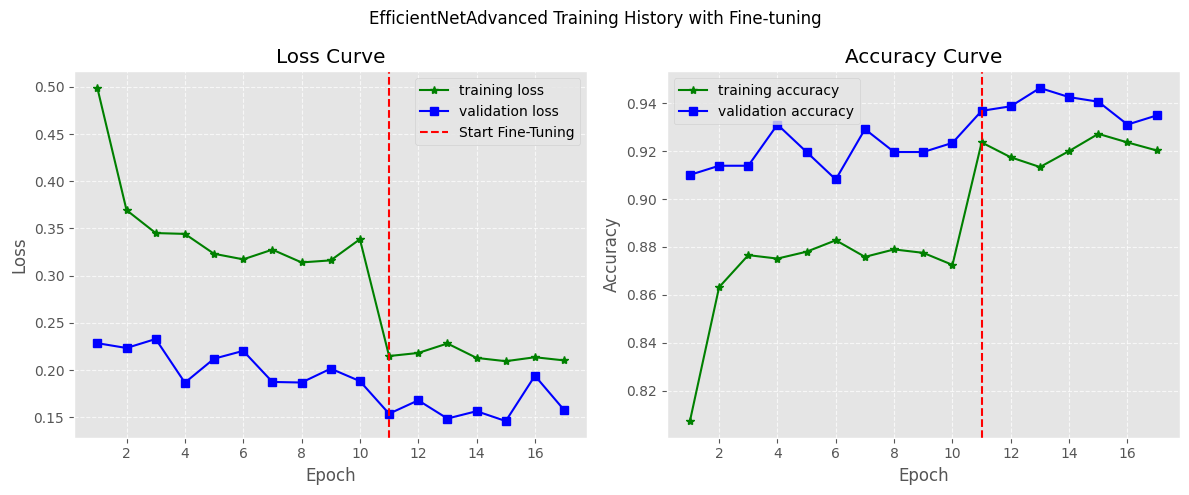

In [32]:
model_saved_name = (
    f"{project_root}/results/{MODEL_NAME}_finetuned"
)
plot_history(
    history,
    f"{MODEL_NAME} Training History with Fine-tuning",
    f"{model_saved_name}.png",
    start_finetuned_epoch=EPOCHS_STAGE_1 + 1,
)

In [33]:
# Load the model again
checkpoint = torch.load(model_save_path)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

Getting predictions:   0%|          | 0/17 [00:00<?, ?it/s]

Getting predictions: 100%|██████████| 17/17 [00:02<00:00,  6.66it/s]


Accuracy score: 0.9580
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       163
           1       0.93      0.96      0.94       181
           2       0.97      0.94      0.95       180

    accuracy                           0.96       524
   macro avg       0.96      0.96      0.96       524
weighted avg       0.96      0.96      0.96       524



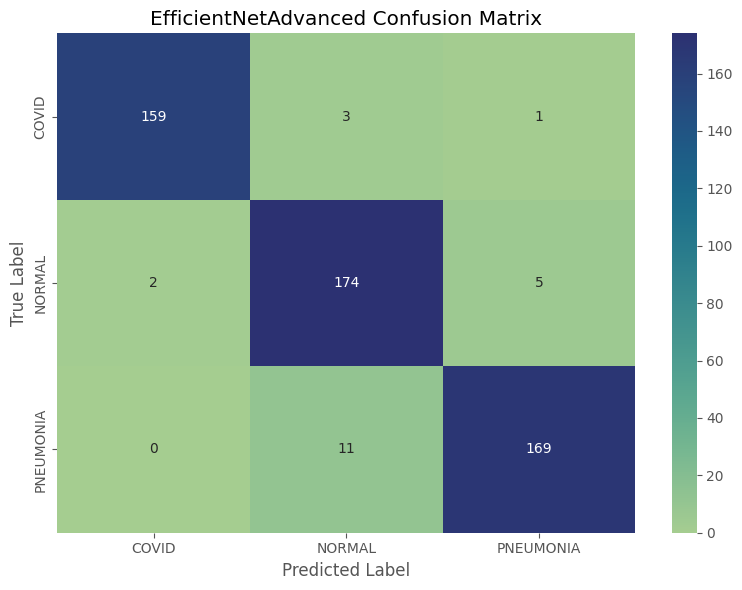

In [34]:
save_path = (
    f"{project_root}/results/{MODEL_NAME}_finetuned_cfm.png"
)
performance(model, test_loader, DEVICE, MODEL_NAME, class_names=CLASSES, save_path=save_path)

In [28]:
history["MODEL_SAVED_PATH"] = model_save_path
# Save history
json_path = os.path.join(
    project_root,
    f"results/{MODEL_NAME}_finetuned_history.json",
)
save_experiment_json(history, json_path)

History saved to /Users/mac/Desktop/Code/Personal_Project/VNUK/xray_chest_classification/results/EfficientNetAdvanced_finetuned_history.json


## 5. Hyperparameter tuning using RayTune

# 6. Model Evaluation with Grad-Cam